## Information

- 본 문서는 Google Colab으로 작성되었습니다. 데이터셋의 경로를 이용자에 맞게 설정해 주셔야 합니다. 
- 데이터셋은 얼굴 이미지를 직접 수집해 활용하였습니다. 
- 앞서 test_age.ipynb에서 선정한 3개의 모델의 finetuning을 시행하였습니다.

## Import & Drive Mount

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import re
from PIL import Image

In [3]:
tf.__version__

'2.5.0'

In [4]:
keras.__version__

'2.5.0'

In [5]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls -l /content/drive/My\ Drive/[양재]\ 1조/dataset/age_data.zip

-rw------- 1 root root 20299135 Jun  2 14:36 '/content/drive/My Drive/[양재] 1조/dataset/age_data.zip'


## Data Preprocessing

In [7]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/age_data.zip

Archive:  /content/drive/My Drive/[양재] 1조/dataset/age_data.zip
   creating: train/
   creating: train/teen/
  inflating: train/teen/20210511154436.jpg  
  inflating: train/teen/20210511134425.jpg  
  inflating: train/teen/20210511144923.jpg  
  inflating: train/teen/20210511132803.jpg  
  inflating: train/teen/20210511162125.jpg  
  inflating: train/teen/20210511111619.jpg  
  inflating: train/teen/20210511154713.jpg  
  inflating: train/teen/20210511134410.jpg  
  inflating: train/teen/20210511140005.jpg  
  inflating: train/teen/20210511163155_rp.jpg  
  inflating: train/teen/20210511133826.jpg  
  inflating: train/teen/20210511113735.jpg  
  inflating: train/teen/20210511144707.jpg  
  inflating: train/teen/20210511163120_rp.jpg  
  inflating: train/teen/20210511140001.jpg  
  inflating: train/teen/20210511132643.jpg  
  inflating: train/teen/20210511132506.jpg  
  inflating: train/teen/20210511142539.jpg  
  inflating: train/teen/20210511163246_rp.jpg  
  inflating: train/teen/2021

### Generate Data

In [8]:
#Gray scaling
train_dir, valid_dir = 'train/', 'valid/'

age_list = ['teen', 'young', 'adult', 'senior']
dir_sort = [train_dir, valid_dir]

for dir in dir_sort:
    for age in age_list:

        datum_path = dir + age + '/'

        for datum in os.listdir(datum_path):

            im = Image.open(datum_path + datum) 
            im.convert('L').save(datum_path + datum)

In [9]:
#Image augmentation
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip = True,
                               brightness_range = [0.3, 0.7],
                               )

valid_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(train_dir,
                                           target_size = (200,200),
                                           batch_size = 50,
                                           class_mode = 'categorical')

valid_data = valid_gen.flow_from_directory(valid_dir,
                                         target_size = (200,200),
                                         batch_size = 50,
                                         shuffle = False,
                                         class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 262 images belonging to 4 classes.


In [10]:
print(f'- Train data : {len(train_data):4d} batches')
print(f'- Valid data  : {len(valid_data):4d} batches')

- Train data :   13 batches
- Valid data  :    6 batches


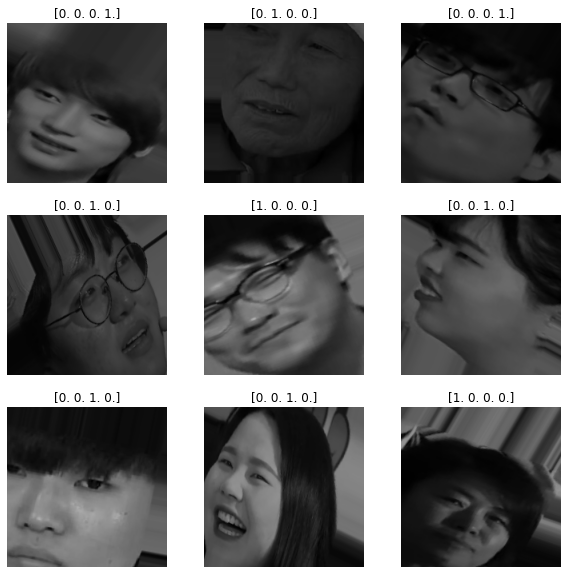

In [11]:
#train data 시각화 (디렉토리 순서대로 0 : adult 36~59 / 1 : senior 60~ / 2 : teen 14~19 / 3 : young 20~34)
images = train_data[0][0][:9]
labels = train_data[0][1][:9]

plt.figure(figsize = (10,10))

for i in range(9) :
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis(False)

plt.show()

### test dataset


In [12]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/test.zip

Archive:  /content/drive/My Drive/[양재] 1조/dataset/test.zip
  inflating: test/남자청년.jpg   
  inflating: test/남자청소년.jpg  
  inflating: test/아저씨.jpg      
  inflating: test/아줌마.jpg      
  inflating: test/여자청년.jpg   
  inflating: test/여자청소년.jpg  
  inflating: test/할머니.jpg      
  inflating: test/할아버지.jpg   


## Define function

### loss & accuracy visualization

In [13]:
def draw_graph(hist):
  plt.figure(figsize = (16,6))
  
  #loss
  plt.subplot(1,2,1)
  plt.plot(hist.epoch, hist.history['loss'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_loss'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train & Valid Loss')
  plt.legend()
  
  #accuracy
  plt.subplot(1,2,2)
  plt.plot(hist.epoch, hist.history['accuracy'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train & Valid Accuracy')
  plt.legend()

  plt.show()

### evaluate test data

In [14]:
#test 파일 리스트업
path = 'test/'
file_list = os.listdir(path)

label_text = ['adult','senior','teen','young']

In [15]:
import cv2
import random

def softmax(x): 
  m = np.max(x)
  sm = np.exp(x - m)/np.sum(np.exp(x - m)) 
  return sm

def evaluate_testdata(model):

  plt.figure(figsize = (8, 16))

  for n in range(len(file_list)):
    #이미지 경로 추출 
    image_path = 'test/' + file_list[n]

    #이미지 출력 
    plt.subplot(8 , 2, n * 2 + 1) 
    plt.imshow(plt.imread(image_path)) 
    plt.axis('off')

    #Top 예측값 출력 공간 
    plt.subplot(8 , 2 , n * 2 + 2)

    #이미지 크기 변경 및 정규화 
    img = cv2.imread(image_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize = (200, 200))  # target size와 동일하게 변경
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)

    #이미지 분류 
    logits = model.predict(img)[0] 
    prediction = softmax(logits)

    #예측값
    predict = prediction.argsort()[::-1][:] 
    labels = [label_text[index] for index in predict]
    
    #Top 막대그래프 출력 
    plt.barh(range(4), prediction[predict][::-1] * 100) 
    plt.yticks(range(4), labels[::-1])

## VGG16

### Modeling

In [16]:
#Model loading
from keras.models import load_model

model_V = load_model('/content/drive/My Drive/[양재] 1조/models/model_V.h5')

model_V.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [17]:
#Finetuning : 마지막 block만 unfreezing 후 학습
from keras import layers, optimizers

for layer in model_V.layers[0].layers :
    if layer.name.startswith('block_5') : layer.trainable = True
    else : layer.trainable = False

model_V.summary()

#model compiling
model_V.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000003),
              metrics = ['accuracy', 'Precision', 'Recall'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [18]:
#model fitting
%%time

hist_V = model_V.fit(train_data,
                 epochs = 30,
                 validation_data = valid_data)

Epoch 1/30
13/13 [==============================] - 65s 962ms/step - loss: 0.3968 - accuracy: 0.8435 - precision: 0.8791 - recall: 0.8173 - val_loss: 0.6934 - val_accuracy: 0.7710 - val_precision: 0.7959 - val_recall: 0.7443
Epoch 2/30
13/13 [==============================] - 7s 559ms/step - loss: 0.3507 - accuracy: 0.8790 - precision: 0.9112 - recall: 0.8420 - val_loss: 0.6861 - val_accuracy: 0.7748 - val_precision: 0.8000 - val_recall: 0.7481
Epoch 3/30
13/13 [==============================] - 7s 554ms/step - loss: 0.3888 - accuracy: 0.8439 - precision: 0.8719 - recall: 0.8247 - val_loss: 0.6836 - val_accuracy: 0.7824 - val_precision: 0.7935 - val_recall: 0.7481
Epoch 4/30
13/13 [==============================] - 7s 560ms/step - loss: 0.3593 - accuracy: 0.8662 - precision: 0.9106 - recall: 0.8198 - val_loss: 0.6833 - val_accuracy: 0.7824 - val_precision: 0.7960 - val_recall: 0.7595
Epoch 5/30
13/13 [==============================] - 7s 553ms/step - loss: 0.4297 - accuracy: 0.8234 - p

### Evaluation

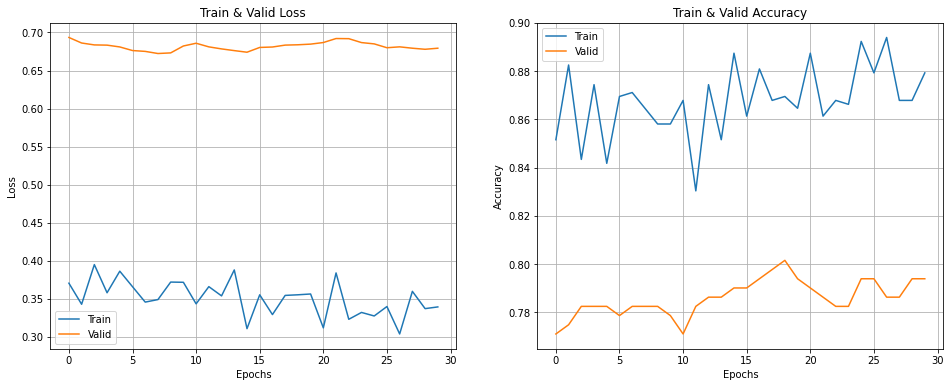

In [19]:
#loss & accuracy visualization
draw_graph(hist_V)

In [20]:
#model evaluation
loss_V, acc_V , pre_V, rec_V = model_V.evaluate(valid_data)

#f1 score
f1_V = (2 * pre_V * rec_V / (pre_V + rec_V))

print('\n* Loss')
print(f'==> {loss_V:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V:.5f}')

print('\n* Precision')
print(f'==> {pre_V:.5f}')

print('\n* Recall')
print(f'==> {rec_V:.5f}')

print('\n* F1 Score')
print(f'==> {f1_V:.5f}')

6/6 [==============================] - 1s 173ms/step - loss: 0.6793 - accuracy: 0.7939 - precision: 0.8000 - recall: 0.7634

* Loss
==> 0.67931

* Accuracy
==> 0.79389

* Precision
==> 0.80000

* Recall
==> 0.76336

* F1 Score
==> 0.78125


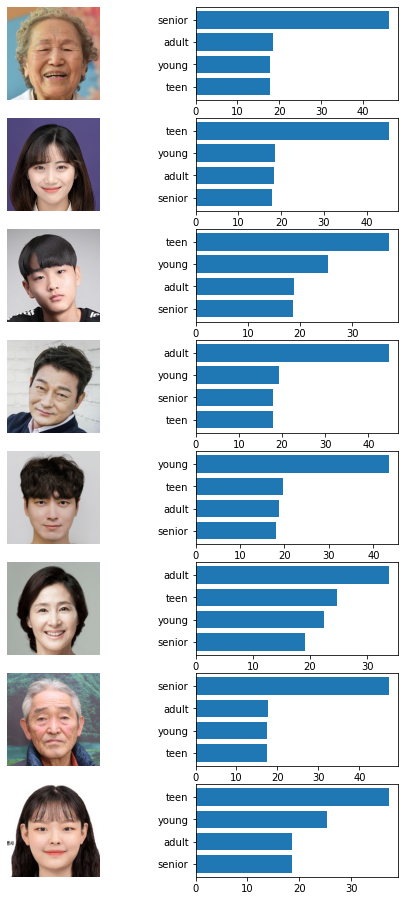

In [21]:
#test visualization
evaluate_testdata(model_V)

## VGG19

### Modeling

In [22]:
#Model loading
from keras.models import load_model

model_V19 = load_model('/content/drive/My Drive/[양재] 1조/models/model_V19.h5')

model_V19.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

In [23]:
#Finetuning : 마지막 block만 unfreezing 후 학습
from keras import layers, optimizers

for layer in model_V19.layers[0].layers :
    if layer.name.startswith('block_5') : layer.trainable = True
    else : layer.trainable = False

model_V19.summary()

#model compiling
model_V19.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000003),
              metrics = ['accuracy', 'Precision', 'Recall'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

In [24]:
#model fitting
%%time

hist_V19 = model_V19.fit(train_data,
                 epochs = 30,
                 validation_data = valid_data)

Epoch 1/30
13/13 [==============================] - 11s 666ms/step - loss: 0.3082 - accuracy: 0.8885 - precision: 0.9070 - recall: 0.8578 - val_loss: 0.7215 - val_accuracy: 0.7519 - val_precision: 0.7720 - val_recall: 0.7366
Epoch 2/30
13/13 [==============================] - 8s 595ms/step - loss: 0.3033 - accuracy: 0.8976 - precision: 0.9102 - recall: 0.8770 - val_loss: 0.7310 - val_accuracy: 0.7405 - val_precision: 0.7640 - val_recall: 0.7290
Epoch 3/30
13/13 [==============================] - 8s 610ms/step - loss: 0.3328 - accuracy: 0.8863 - precision: 0.9077 - recall: 0.8680 - val_loss: 0.7214 - val_accuracy: 0.7443 - val_precision: 0.7680 - val_recall: 0.7328
Epoch 4/30
13/13 [==============================] - 8s 604ms/step - loss: 0.3354 - accuracy: 0.8876 - precision: 0.9088 - recall: 0.8650 - val_loss: 0.7122 - val_accuracy: 0.7557 - val_precision: 0.7742 - val_recall: 0.7328
Epoch 5/30
13/13 [==============================] - 8s 603ms/step - loss: 0.3373 - accuracy: 0.8723 - p

### Evaluation

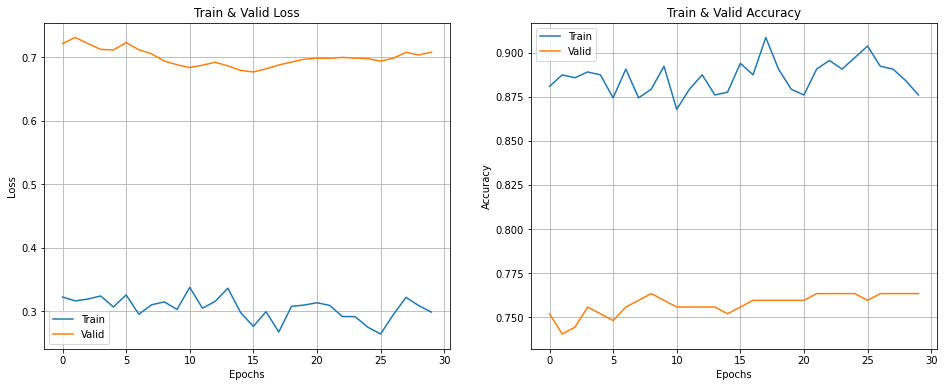

In [25]:
#loss & accuracy visualization
draw_graph(hist_V19)

In [26]:
loss_V19, acc_V19 , pre_V19, rec_V19 = model_V19.evaluate(valid_data)

#f1 score
f1_V19 = (2 * pre_V19 * rec_V19 / (pre_V19 + rec_V19))

print('\n* Loss')
print(f'==> {loss_V19:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V19:.5f}')

print('\n* Precision')
print(f'==> {pre_V19:.5f}')

print('\n* Recall')
print(f'==> {rec_V19:.5f}')

print('\n* F1 Score')
print(f'==> {f1_V19:.5f}')

6/6 [==============================] - 1s 211ms/step - loss: 0.7080 - accuracy: 0.7634 - precision: 0.7791 - recall: 0.7405

* Loss
==> 0.70797

* Accuracy
==> 0.76336

* Precision
==> 0.77912

* Recall
==> 0.74046

* F1 Score
==> 0.75930


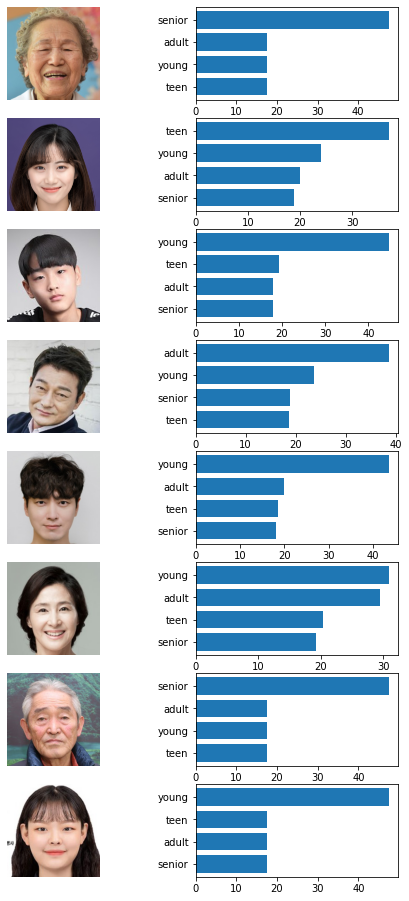

In [27]:
#test visualization
evaluate_testdata(model_V19)



## DenseNet201

### Modeling

In [28]:
#Model loading
from keras.models import load_model

model_D201 = load_model('/content/drive/My Drive/[양재] 1조/models/model_D201.h5')

model_D201.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 69120)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               17694976  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [29]:
#Finetuning : 마지막 block만 unfreezing 후 학습
from keras import layers, optimizers

for layer in model_D201.layers[0].layers :
    if layer.name.startswith('conv') : layer.trainable = True
    else : layer.trainable = False

model_D201.summary()

#model compiling
model_D201.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000003),
              metrics = ['accuracy', 'Precision', 'Recall'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 69120)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               17694976  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [30]:
#model fitting
%%time

hist_D201 = model_D201.fit(train_data,
                 epochs = 30,
                 validation_data = valid_data)

Epoch 1/30
13/13 [==============================] - 88s 3s/step - loss: 0.4220 - accuracy: 0.8441 - precision: 0.8826 - recall: 0.8086 - val_loss: 0.7110 - val_accuracy: 0.7595 - val_precision: 0.7805 - val_recall: 0.7328
Epoch 2/30
13/13 [==============================] - 10s 805ms/step - loss: 0.4196 - accuracy: 0.8284 - precision: 0.8696 - recall: 0.8085 - val_loss: 0.7113 - val_accuracy: 0.7595 - val_precision: 0.7842 - val_recall: 0.7214
Epoch 3/30
13/13 [==============================] - 10s 766ms/step - loss: 0.3991 - accuracy: 0.8327 - precision: 0.8725 - recall: 0.7918 - val_loss: 0.7021 - val_accuracy: 0.7595 - val_precision: 0.7910 - val_recall: 0.7366
Epoch 4/30
13/13 [==============================] - 10s 768ms/step - loss: 0.3383 - accuracy: 0.8754 - precision: 0.8932 - recall: 0.8264 - val_loss: 0.6921 - val_accuracy: 0.7672 - val_precision: 0.7846 - val_recall: 0.7366
Epoch 5/30
13/13 [==============================] - 10s 780ms/step - loss: 0.4065 - accuracy: 0.8408 - 

### Evaluation

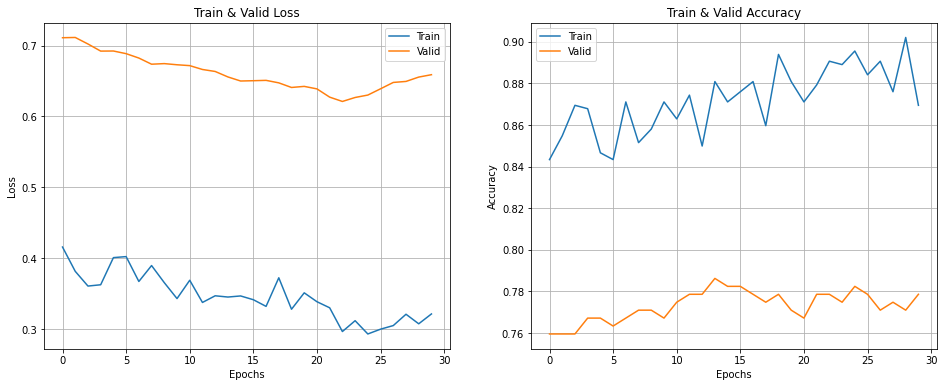

In [31]:
#loss & accuracy visualization
draw_graph(hist_D201)

In [32]:
loss_D201, acc_D201 , pre_D201, rec_D201 = model_D201.evaluate(valid_data)

#f1 score
f1_D201 = (2 * pre_D201 * rec_D201 / (pre_D201 + rec_D201))

print('\n* Loss')
print(f'==> {loss_D201:.5f}')

print('\n* Accuracy')
print(f'==> {acc_D201:.5f}')

print('\n* Precision')
print(f'==> {pre_D201:.5f}')

print('\n* Recall')
print(f'==> {rec_D201:.5f}')

print('\n* F1 Score')
print(f'==> {f1_D201:.5f}')

6/6 [==============================] - 1s 171ms/step - loss: 0.6588 - accuracy: 0.7786 - precision: 0.7959 - recall: 0.7443

* Loss
==> 0.65883

* Accuracy
==> 0.77863

* Precision
==> 0.79592

* Recall
==> 0.74427

* F1 Score
==> 0.76923


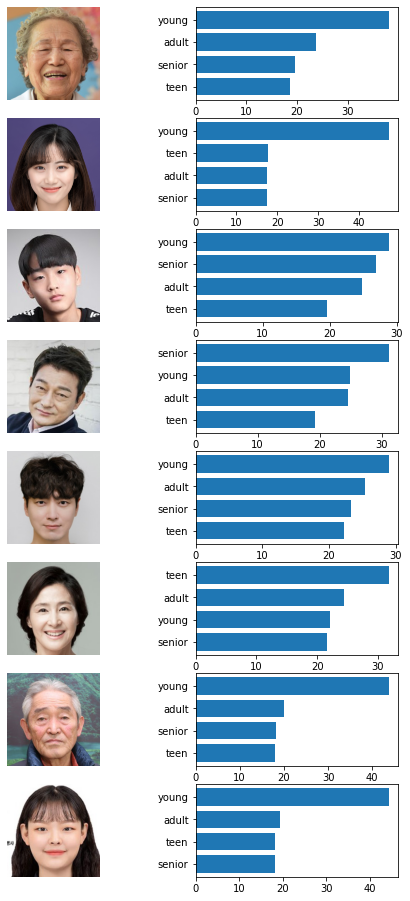

In [33]:
#test visualization
evaluate_testdata(model_D201)

## Result


In [34]:
import pandas as pd

result = pd.DataFrame(data = {'Name' : ['VGG16', 'VGG19', 'DenseNet201'],
                              'Accuracy' : [acc_V, acc_V19, acc_D201], 
                              'Loss' : [loss_V, loss_V19, loss_D201],
                              'F1 score' : [f1_V, f1_V19, f1_D201],
                              })

result = result.sort_values(by = ['Accuracy'], ascending = False)
result

,Name,Accuracy,Loss,F1 score
0,VGG16,0.793893,0.679309,0.781250
2,DenseNet201,0.778626,0.658834,0.769231
1,VGG19,0.763359,0.707971,0.759295


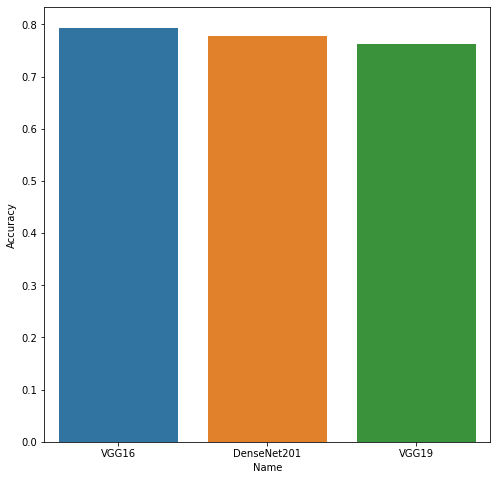

In [35]:
#Accuracy 순위대로 표시
import seaborn as sns

plt.figure(figsize = (8,8))
sns.barplot(data = result, x = 'Name', y = 'Accuracy')

plt.show()

### Model saving

In [36]:
model_names = ['age_V', 'age_V19', 'age_D201']
model_list = [model_V, model_V19, model_D201]

for name, model in zip(model_names, model_list):
    try:
        json = model.to_json()
    except:
        continue

    model.save(f'/content/drive/My Drive/[양재] 1조/models/{name}.h5')
    with open(f'/content/drive/My Drive/[양재] 1조/models/{name}.json', 'w') as json_file :
        json_file.write(json)

### Model selection
- loss와 accuracy 및 f1 score, 그리고 test evaluation 및 실제 데이터를 input했을 때의 분류 정확도를 종합하여 비교한 결과, 가장 높은 성능을 보인 VGG16을 최종 선정하였습니다.